# This notebook generates plots for the ablation studies in the paper.

You will need to first generate embeddings using the notebook generate_yearbook_embeddings

In [1]:
# import things
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from PIL import Image, ImageDraw
from sklearn.datasets import make_blobs, make_classification
from sklearn.metrics.pairwise import rbf_kernel
from weighted_exemplars import *

In [2]:
# image data
info = pd.read_csv("yearbook/yb_info.csv")
image_dir = 'yearbook/faces/F'
image_list = [os.path.join(image_dir, name) for name in os.listdir(image_dir) if name.endswith('.png')]
year_list = []
for name in image_list:
    year_list.append(int(name[17:21]))
info = pd.DataFrame({'filename': image_list, 'year': year_list})
info['decade'] = (10*np.floor(info.year/10)).astype(int)

embeddings = np.genfromtxt("yearbook/yb_embeddings_all.csv", delimiter=',')

targets = {}
target_list = []
for i in range(12):
    decade = 1900+10*i
    targets[decade] = np.where(info.decade==decade)[0]
    target_list.append(targets[decade])

In [3]:
# get the median kernel
test_kernel = rbf_kernel(embeddings, gamma=1.)
unique_kernel = test_kernel[np.triu_indices(test_kernel.shape[0], k = 1)]
sigsq_face = -np.log(np.median(unique_kernel))/2
alp_face = 1./(2*sigsq_face)
K_medface = rbf_kernel(embeddings, gamma=alp_face) 

# get the per decade kernel

for target in target_list:
    test_kernel = rbf_kernel(embeddings[target, :], gamma=1.)
    unique_kernel = test_kernel[np.triu_indices(test_kernel.shape[0], k = 1)]
    sigsq_face = -np.log(np.median(unique_kernel))/2
    alp_face = 1./(2*sigsq_face)
    K_medface += rbf_kernel(embeddings, gamma=alp_face) 
    
K_medface = K_medface / (len(target_list)+1)

# various thresholds--times and number of exemplars

In [4]:
time_limit = 60*60 # 1 hours
thresholds = [0.2, 0.1, 0.02, 0.05, 0.01, 0.005]
dmmd_times = []
dmmd_M = []
dmmd_opt_times = []
dmmd_opt_M = []
protodash_times = []
protodash_M = []
num_targets=len(target_list)

dmmd_timeout = False
dmmd_opt_timeout = False
protodash_timeout = False
for threshold in thresholds:
    print('threshold={}'.format(threshold))
    
    
    if dmmd_timeout is False:
        print('DMMD')
        tic = time.time()
        exemplars, weights =weighted_exemplars(K_medface, 
                                                                    target_list, 
                                                                    MMD_threshold=threshold, 
                                                                    relearn_weights=False, 
                                                                    return_mmds=False,
                                                                    time_limit=time_limit
                                                                    )
        toc = time.time()

        mmd = [[calculate_mmd(K_medface, target_list[t], exemplars, Y_weights=weights[t]) for t in range(num_targets)]]
        if np.all(np.array(mmd) < threshold):
            dmmd_times.append(toc-tic)
            dmmd_M.append(len(exemplars))

        else:
            dmmd_timeout = True
    
    if dmmd_opt_timeout is False:
        print('DMMD-OPT')
        tic = time.time()
        exemplars, weights=weighted_exemplars(K_medface, 
                                                                    target_list, 
                                                                    MMD_threshold=threshold, 
                                                                    relearn_weights=True, 
                                                                    return_mmds=False,
                                                                    time_limit=time_limit
                                                                    )
        toc = time.time()
        mmd = [[calculate_mmd(K_medface, target_list[t], exemplars, Y_weights=weights[t]) for t in range(num_targets)]]
        if np.all(np.array(mmd) < threshold):
            dmmd_opt_times.append(toc-tic)
            dmmd_opt_M.append(len(exemplars))

        else:
            dmmd_opt_timeout = True
    if protodash_timeout is False:
        print('protodash')
        tic = time.time()
        exemplars, weights = protodash(K_medface, target_list, MMD_threshold=threshold, 
                                       return_mmds=False, time_limit=time_limit)

        toc = time.time()
        mmd = [[calculate_mmd(K_medface, target_list[t], exemplars, Y_weights=weights[t]) for t in range(num_targets)]]
        if np.all(np.array(mmd) < threshold):
            protodash_times.append(toc-tic)
            protodash_M.append(len(exemplars))

        else:
            protodash_timeout = True

threshold=0.2
DMMD
adding exemplar 2
4.793494939804077
adding exemplar 3
9.601961135864258
adding exemplar 4
13.335774898529053
adding exemplar 5
16.779254913330078
DMMD-OPT
adding exemplar 2
7.146795749664307
adding exemplar 3
14.426000833511353
adding exemplar 4
20.928233861923218
adding exemplar 5
27.365567922592163
protodash
adding exemplar 1
27.738677978515625
adding exemplar 2
55.69991898536682
adding exemplar 3
83.41691875457764
adding exemplar 4
111.5181257724762
adding exemplar 5
131.5784468650818
adding exemplar 6
142.08872199058533
adding exemplar 7
149.117506980896
threshold=0.1
DMMD
adding exemplar 2
4.729883193969727
adding exemplar 3
9.182225942611694
adding exemplar 4
13.519617080688477
adding exemplar 5
17.792213916778564
adding exemplar 6
21.704387187957764
adding exemplar 7
25.207175970077515
adding exemplar 8
28.61496901512146
adding exemplar 9
31.947537899017334
DMMD-OPT
adding exemplar 2
7.347468852996826
adding exemplar 3
14.826612949371338
adding exemplar 4
21.8

50.886595010757446
adding exemplar 14
54.597815990448
adding exemplar 15
58.328487157821655
adding exemplar 16
62.05663204193115
adding exemplar 17
65.71355199813843
adding exemplar 18
69.19319605827332
adding exemplar 19
72.66560411453247
adding exemplar 20
76.06204199790955
adding exemplar 21
79.37289118766785
DMMD-OPT
adding exemplar 2
7.31369423866272
adding exemplar 3
14.727696180343628
adding exemplar 4
21.82897925376892
adding exemplar 5
28.89686918258667
adding exemplar 6
35.93710207939148
adding exemplar 7
43.08022713661194
adding exemplar 8
50.2942099571228
adding exemplar 9
57.55682396888733
adding exemplar 10
65.13568830490112
adding exemplar 11
72.7322301864624
adding exemplar 12
80.20335102081299
adding exemplar 13
87.74724411964417
adding exemplar 14
95.27350401878357
adding exemplar 15
102.91121912002563
adding exemplar 16
110.64523530006409
adding exemplar 17
118.5026752948761
adding exemplar 18
126.49805307388306
adding exemplar 19
134.35771799087524
protodash
adding 

656.877387046814
adding exemplar 54
673.6007499694824
adding exemplar 55
690.2327179908752
adding exemplar 56
708.3538601398468
adding exemplar 57
726.5987989902496
adding exemplar 58
744.6230289936066
adding exemplar 59
762.9906311035156
adding exemplar 60
782.6796441078186
adding exemplar 61
802.3894009590149
adding exemplar 62
821.499794960022
adding exemplar 63
839.1423559188843
adding exemplar 64
859.2096481323242
adding exemplar 65
886.2031960487366
adding exemplar 66
910.1518068313599
adding exemplar 67
936.2065460681915
adding exemplar 68
966.2210359573364
adding exemplar 69
990.0344860553741
adding exemplar 70
1018.8155770301819
adding exemplar 71
1048.3521909713745
adding exemplar 72
1076.8491780757904
adding exemplar 73
1104.6000990867615
adding exemplar 74
1129.636076927185
adding exemplar 75
1157.0607590675354
adding exemplar 76
1187.0172510147095
adding exemplar 77
1224.0640528202057
adding exemplar 78
1254.285434961319
adding exemplar 79
1278.8529739379883
adding exempla

422.0639889240265
adding exemplar 102
426.42777013778687
adding exemplar 103
430.752069234848
adding exemplar 104
435.0561661720276
adding exemplar 105
439.3611550331116
adding exemplar 106
443.6915051937103
adding exemplar 107
448.0295422077179
adding exemplar 108
452.3837881088257
adding exemplar 109
456.73289489746094
adding exemplar 110
461.1302070617676
adding exemplar 111
465.4568250179291
adding exemplar 112
469.7869791984558
adding exemplar 113
474.14418625831604
adding exemplar 114
478.48627400398254
adding exemplar 115
482.8922653198242
adding exemplar 116
487.32488107681274
adding exemplar 117
491.7775402069092
adding exemplar 118
496.17325615882874
adding exemplar 119
500.5748701095581
adding exemplar 120
504.9634861946106
adding exemplar 121
509.3615469932556
adding exemplar 122
513.7895081043243
adding exemplar 123
518.2425191402435
adding exemplar 124
522.7106630802155
adding exemplar 125
527.0936210155487
adding exemplar 126
531.6517162322998
adding exemplar 127
536.127

1694.62459897995
adding exemplar 93
1727.2553169727325
adding exemplar 94
1756.8977427482605
adding exemplar 95
1790.789116859436
adding exemplar 96
1829.859050989151
adding exemplar 97
1863.6539587974548
adding exemplar 98
1895.3919758796692
adding exemplar 99
1942.997750043869
adding exemplar 100
1989.3653478622437
adding exemplar 101
2045.2278289794922
adding exemplar 102
2102.9753358364105
adding exemplar 103
2162.546872854233
adding exemplar 104
2219.17724275589
adding exemplar 105
2276.635766029358
adding exemplar 106
2335.8442928791046
adding exemplar 107
2389.0109519958496
adding exemplar 108
2441.6482570171356
adding exemplar 109
2497.97270488739
adding exemplar 110
2560.6123049259186
adding exemplar 111
2622.377017736435
adding exemplar 112
2688.1087279319763
adding exemplar 113
2750.6104340553284
adding exemplar 114
2816.2373139858246
adding exemplar 115
2885.9378728866577
adding exemplar 116
2949.194116830826
adding exemplar 117
3016.271985769272
adding exemplar 118
3082.70

In [5]:
import tol_colors as tc
schemes = tc.tol_cset()
print(schemes)
cset = tc.tol_cset('high-contrast')
colors = list(cset)

('bright', 'high-contrast', 'vibrant', 'muted', 'medium-contrast', 'light')


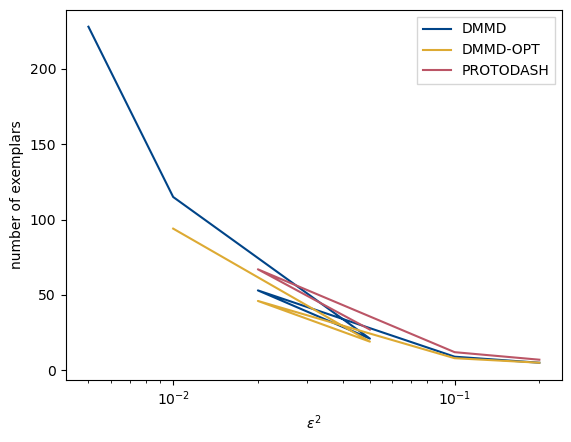

In [6]:

fig, ax = plt.subplots(1,1)
l1, =ax.plot(thresholds[:len(dmmd_M)], dmmd_M, color=colors[0])
l2, =ax.plot(thresholds[:len(dmmd_opt_M)], dmmd_opt_M, color=colors[1])
l3, = ax.plot(thresholds[:len(protodash_M)], protodash_M, color=colors[2])
ax.set_xscale('log')
ax.set_xlabel(r'$\epsilon^2$')
ax.set_ylabel('number of exemplars')
ax.legend(handles = [l1,l2,l3] , labels=['DMMD', 'DMMD-OPT', 'PROTODASH'],loc='upper right',fancybox=False, shadow=False)

plt.show()

# next, let run as many as possible in an hour

In [7]:
# our alg
exemplars_dmmd_2, weights_dmmd_2, mmds_dmmd_2, times_dmmd_2 = weighted_exemplars(K_medface, 
                                                                                 target_list, 
                                                                                 M=10000, 
                                                                                 relearn_weights=False,
                                                                                 return_mmds=True,
                                                                                 time_limit=time_limit)

adding exemplar 2
4.668977975845337
adding exemplar 3
9.32790493965149
adding exemplar 4
13.977507829666138
adding exemplar 5
18.289678812026978
adding exemplar 6
22.533352851867676
adding exemplar 7
26.691370010375977
adding exemplar 8
30.89516282081604
adding exemplar 9
35.133304834365845
adding exemplar 10
39.256152868270874
adding exemplar 11
43.44365072250366
adding exemplar 12
47.62004375457764
adding exemplar 13
51.82819986343384
adding exemplar 14
56.04930377006531
adding exemplar 15
60.29714107513428
adding exemplar 16
64.50939869880676
adding exemplar 17
68.69805383682251
adding exemplar 18
72.92032098770142
adding exemplar 19
77.15274500846863
adding exemplar 20
81.3740918636322
adding exemplar 21
85.63846778869629
adding exemplar 22
89.9500949382782
adding exemplar 23
94.1617968082428
adding exemplar 24
98.38812708854675
adding exemplar 25
102.6222198009491
adding exemplar 26
106.8615050315857
adding exemplar 27
111.10306692123413
adding exemplar 28
115.35452699661255
addin

969.2349939346313
adding exemplar 220
974.2066099643707
adding exemplar 221
978.9377648830414
adding exemplar 222
983.694983959198
adding exemplar 223
988.4386539459229
adding exemplar 224
993.2580187320709
adding exemplar 225
998.0136070251465
adding exemplar 226
1002.7887580394745
adding exemplar 227
1007.5557987689972
adding exemplar 228
1012.4555809497833
adding exemplar 229
1017.2045998573303
adding exemplar 230
1022.0712866783142
adding exemplar 231
1026.8416588306427
adding exemplar 232
1031.6488308906555
adding exemplar 233
1036.4502820968628
adding exemplar 234
1041.238639831543
adding exemplar 235
1046.0866360664368
adding exemplar 236
1050.9616458415985
adding exemplar 237
1055.8011338710785
adding exemplar 238
1060.6312668323517
adding exemplar 239
1065.4456548690796
adding exemplar 240
1070.282274723053
adding exemplar 241
1075.1219327449799
adding exemplar 242
1080.0136787891388
adding exemplar 243
1084.8521647453308
adding exemplar 244
1089.7103109359741
adding exemplar 

adding exemplar 431
2060.911566734314
adding exemplar 432
2066.4966189861298
adding exemplar 433
2072.087625980377
adding exemplar 434
2077.604616880417
adding exemplar 435
2083.159008026123
adding exemplar 436
2088.715091943741
adding exemplar 437
2094.2868518829346
adding exemplar 438
2099.9493639469147
adding exemplar 439
2105.4903450012207
adding exemplar 440
2111.0898628234863
adding exemplar 441
2116.6814439296722
adding exemplar 442
2122.3091909885406
adding exemplar 443
2127.9041290283203
adding exemplar 444
2133.5484068393707
adding exemplar 445
2139.166914701462
adding exemplar 446
2144.8986587524414
adding exemplar 447
2150.503969669342
adding exemplar 448
2156.148521900177
adding exemplar 449
2161.833451986313
adding exemplar 450
2167.4961788654327
adding exemplar 451
2173.1326348781586
adding exemplar 452
2178.7485699653625
adding exemplar 453
2184.387438774109
adding exemplar 454
2190.0976688861847
adding exemplar 455
2195.374223947525
adding exemplar 456
2201.03605794906

adding exemplar 644
3334.5504949092865
adding exemplar 645
3341.0004007816315
adding exemplar 646
3347.3925108909607
adding exemplar 647
3353.854961872101
adding exemplar 648
3360.37810587883
adding exemplar 649
3366.8622920513153
adding exemplar 650
3373.294294834137
adding exemplar 651
3379.749967813492
adding exemplar 652
3386.224128961563
adding exemplar 653
3392.6960978507996
adding exemplar 654
3399.1789367198944
adding exemplar 655
3405.6348869800568
adding exemplar 656
3412.1281428337097
adding exemplar 657
3418.62300491333
adding exemplar 658
3425.1130487918854
adding exemplar 659
3431.5361659526825
adding exemplar 660
3437.9661440849304
adding exemplar 661
3444.4641258716583
adding exemplar 662
3451.106748819351
adding exemplar 663
3457.5560178756714
adding exemplar 664
3464.0841698646545
adding exemplar 665
3470.5759088993073
adding exemplar 666
3477.1525859832764
adding exemplar 667
3483.7153899669647
adding exemplar 668
3490.1850340366364
adding exemplar 669
3496.730731010

In [8]:
# our alg, with post-hoc optimization
exemplars_dmmd_opt_2, weights_opt_dmmd_2, mmds_opt_dmmd_2, times_opt_dmmd_2 = weighted_exemplars(K_medface, 
                                                                                                 target_list, 
                                                                                                 M=10000, 
                                                                                                 relearn_weights=True,
                                                                                                 return_mmds=True,
                                                                                                 time_limit=time_limit
                                                                                                 )

adding exemplar 2
7.299674987792969
adding exemplar 3
14.681112051010132
adding exemplar 4
22.08400821685791
adding exemplar 5
29.226853132247925
adding exemplar 6
36.36065196990967
adding exemplar 7
43.45177412033081
adding exemplar 8
50.72188687324524
adding exemplar 9
58.00804591178894
adding exemplar 10
65.81483507156372
adding exemplar 11
73.18092608451843
adding exemplar 12
80.82530188560486
adding exemplar 13
88.86496305465698
adding exemplar 14
96.79585409164429
adding exemplar 15
106.5465681552887
adding exemplar 16
117.02963495254517
adding exemplar 17
125.90946292877197
adding exemplar 18
134.44309186935425
adding exemplar 19
143.99879693984985
adding exemplar 20
154.61434602737427
adding exemplar 21
164.43092703819275
adding exemplar 22
175.96450090408325
adding exemplar 23
186.36385107040405
adding exemplar 24
196.5164089202881
adding exemplar 25
206.7233350276947
adding exemplar 26
217.9881398677826
adding exemplar 27
228.54649591445923
adding exemplar 28
241.438169002532

In [9]:
# dependent protodash
exemplars_protodash_2, weights_protodash_2, mmds_protodash_2, times_protodash_2 = protodash(K_medface, 
                                                                                            target_list, 
                                                                                            M=10000, 
                                                                                            return_mmds = True, 
                                                                                            time_limit=time_limit
                                                                                           )

adding exemplar 1
25.061232805252075
adding exemplar 2
52.58799481391907
adding exemplar 3
80.3692569732666
adding exemplar 4
107.50697803497314
adding exemplar 5
135.15757012367249
adding exemplar 6
161.60750102996826
adding exemplar 7
188.40819191932678
adding exemplar 8
215.72173285484314
adding exemplar 9
243.1179530620575
adding exemplar 10
270.07577872276306
adding exemplar 11
297.33036184310913
adding exemplar 12
325.5430819988251
adding exemplar 13
354.01925587654114
adding exemplar 14
382.6741991043091
adding exemplar 15
411.0206079483032
adding exemplar 16
438.68996000289917
adding exemplar 17
468.41791701316833
adding exemplar 18
497.605082988739
adding exemplar 19
527.2809958457947
adding exemplar 20
556.8551568984985
adding exemplar 21
587.2591700553894
adding exemplar 22
617.8105328083038
adding exemplar 23
648.6177470684052
adding exemplar 24
679.9340059757233
adding exemplar 25
711.7681810855865
adding exemplar 26
743.4592440128326
adding exemplar 27
776.1472451686859
a

In [10]:
mmds_protodash_2 = np.array(mmds_protodash_2)
mmds_protodash_2 = np.reshape(mmds_protodash_2, (len(mmds_protodash_2), 12))
mmds_dmmd_2 = np.array(mmds_dmmd_2)
mmds_opt_dmmd_2 = np.array(mmds_opt_dmmd_2)

('bright', 'high-contrast', 'vibrant', 'muted', 'medium-contrast', 'light')


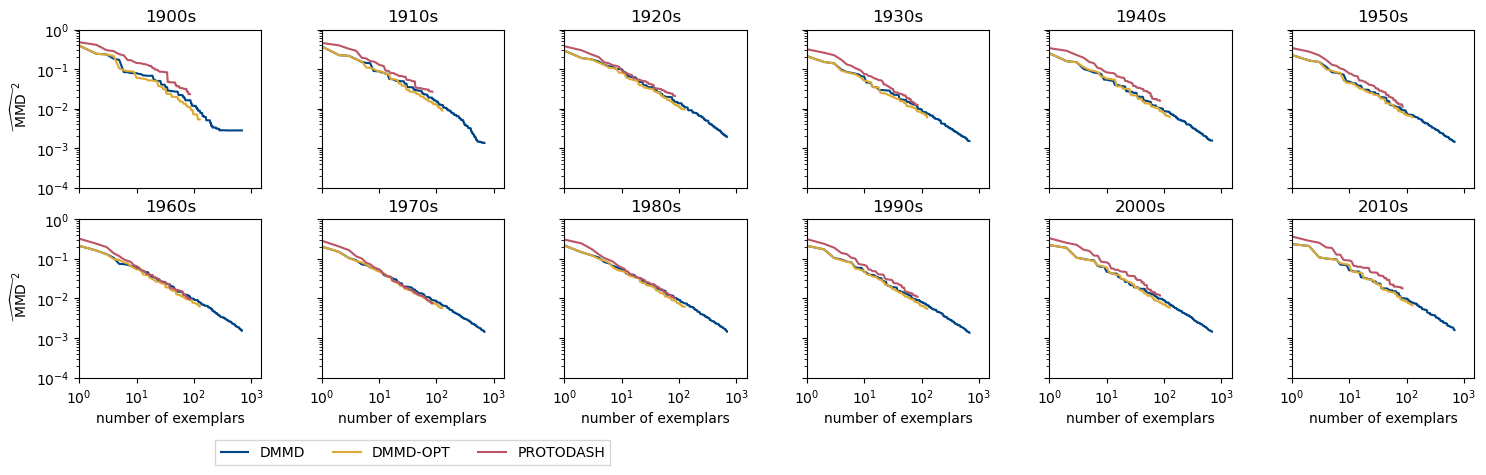

In [11]:
import tol_colors as tc
schemes = tc.tol_cset()
print(schemes)
cset = tc.tol_cset('high-contrast')
colors = list(cset)

fig, ax = plt.subplots(2, 6, figsize=(18, 6), sharex=True, sharey=True)
decades = 1900 + 10 * np.arange(12).astype(int)
k = 0
for i in range(2):
    for j in range(6):
        l1, =ax[i, j].plot(mmds_dmmd_2[:, k], color=colors[0])#, linestyle='-')
        l2, = ax[i, j].plot(mmds_opt_dmmd_2[:, k], color=colors[1])#, linestyle = ':')
        l3, = ax[i, j].plot(mmds_protodash_2[:, k], color=colors[2])#, linestyle = '--')
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        ax[i, j].set_title('{}s'.format(decades[k]))
        ax[i, j].set_xlim(1, 1500)
        ax[i, j].set_xticks([1, 10, 100, 1000])
        ax[i, j].set_ylim(10e-5, 1)
        k += 1
        if i == 1:
            ax[i, j].set_xlabel('number of exemplars')
        if j == 0:
            ax[i, j].set_ylabel(r'$\widehat{\mathrm{~~MMD}}~^2$')
fig.subplots_adjust(bottom=0.3, wspace=0.33)

ax[1,1].legend(handles = [l1,l2,l3] , labels=['DMMD', 'DMMD-OPT', 'PROTODASH'],loc='upper center', 
             bbox_to_anchor=(0.5, -0.35),fancybox=False, shadow=False, ncol=3)
plt.show()
plt.show()

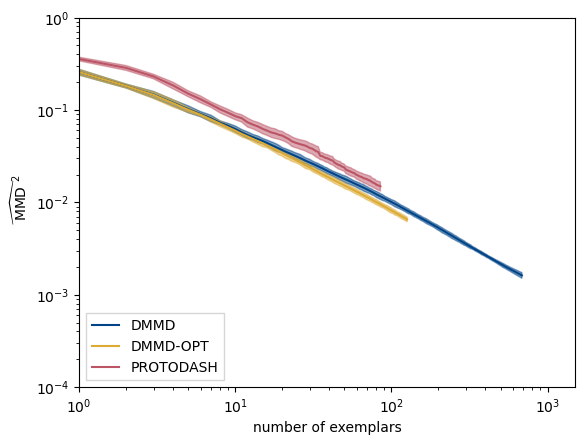

In [15]:
fig, ax = plt.subplots(1,1)
mmds_dmmd_mean = np.mean(mmds_dmmd_2, axis=1)
mmds_dmmd_sterr = np.std(mmds_dmmd_2, axis=1) / np.sqrt(12)
mmds_dmmd_opt_mean = np.mean(mmds_opt_dmmd_2, axis=1)
mmds_dmmd_opt_sterr = np.std(mmds_opt_dmmd_2, axis=1) / np.sqrt(12)
mmds_protodash_mean = np.mean(mmds_protodash_2, axis=1)
mmds_protodash_sterr = np.std(mmds_protodash_2, axis=1) / np.sqrt(12)
decades = 1900 + 10 * np.arange(12).astype(int)

l1, =ax.plot(mmds_dmmd_mean, color=colors[0])#, linestyle='-')
ax.fill_between(np.arange(len(mmds_dmmd_mean)), 
                mmds_dmmd_mean - mmds_dmmd_sterr,
                mmds_dmmd_mean+mmds_dmmd_sterr, 
                color=colors[0], alpha=0.5)
l2, = ax.plot(mmds_dmmd_opt_mean, color=colors[1])#, linestyle = ':')
ax.fill_between(np.arange(len(mmds_dmmd_opt_mean)), 
                mmds_dmmd_opt_mean - mmds_dmmd_opt_sterr,
                mmds_dmmd_opt_mean+mmds_dmmd_opt_sterr, 
                color=colors[1], alpha=0.5)
l3, = ax.plot(mmds_protodash_mean, color=colors[2])#, linestyle = '--')
ax.fill_between(np.arange(len(mmds_protodash_mean)), 
                mmds_protodash_mean - mmds_protodash_sterr,
                mmds_protodash_mean+mmds_protodash_sterr, 
                color=colors[2], alpha=0.5)

ax.set_yscale('log')
                
ax.set_xscale('log')
ax.set_xlim(1, 1500)
ax.set_xticks([1, 10, 100, 1000])
ax.set_ylim(10e-5, 1)
ax.set_xlabel('number of exemplars')
ax.set_ylabel(r'$\widehat{\mathrm{~~MMD}}~^2$')


ax.legend(handles = [l1,l2,l3] , labels=['DMMD', 'DMMD-OPT', 'PROTODASH'],loc='lower left',fancybox=False, shadow=False)
plt.show()
plt.show()

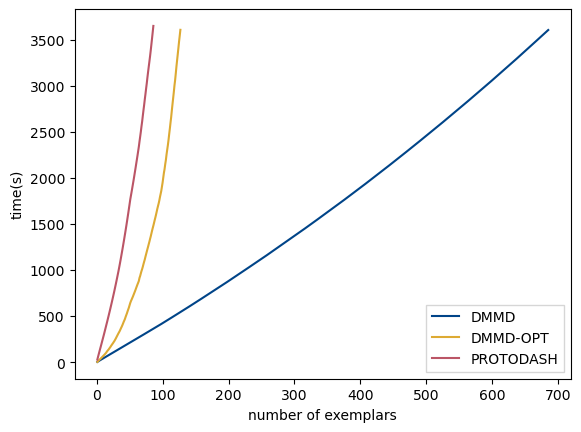

In [16]:
times_dmmd_2 = np.array(times_dmmd_2)
times_opt_dmmd_2 = np.array(times_opt_dmmd_2)
times_protodash_2 = np.array(times_protodash_2)

M_dmmd = 1+np.arange(len(times_dmmd_2))
M_opt_dmmd = 1+np.arange(len(times_opt_dmmd_2))
M_protodash = 1+np.arange(len(times_protodash_2))
fig, ax = plt.subplots(1,1)
l1, =ax.plot(M_dmmd, times_dmmd_2,  color=colors[0])#, linestyle='-')

l2, = ax.plot(M_opt_dmmd, times_opt_dmmd_2, color=colors[1])#, linestyle = ':')

l3, = ax.plot(M_protodash, times_protodash_2, color=colors[2])#, linestyle = '--')


#ax.set_yscale('log')
                
#ax.set_xscale('log')
#ax.set_xlim(1, 1500)
#ax.set_xticks([1, 10, 100, 1000])
#ax.set_ylim(10e-5, 1)
ax.set_ylabel('time(s)')
ax.set_xlabel('number of exemplars')

ax.legend(handles = [l1,l2,l3] , labels=['DMMD', 'DMMD-OPT', 'PROTODASH'],loc='lower right',fancybox=False, shadow=False)
plt.show()
plt.show()